## 📌 考察と工夫

### 🔍 考察：モデル性能とデータ特性の関係

本研究では、スマートリングおよび赤外線アレイセンサから得られた体温データ、および室温・アンケート情報を用いて、主観的な「適温」を予測するモデルを構築しました  
実験の結果LSTM単体モデルが最も高精度（R² ≒ 0.8）であり、特に時系列的な温度変化を踏まえた予測が有効であることが示されました

一方で、**XGBoostやLSTM+XGBoostのハイブリッドモデルは精度がやや劣る結果**となりました。これには以下の要因が関係していると考えられます：

- 訓練データに含まれない温度パターンがテストデータに存在していたため、XGBoostモデルでは汎化が困難
- 全体のデータの各サンプル数が384件と限られていたため、複雑なモデルでは過学習や未学習の傾向が見られた
- ハイブリッドモデルでは、LSTMの中間特徴がXGBoostで有効活用され、XGBoostよりも良い精度だった

また損失グラフにおいて、訓練損失のほうが検証損失よりも途中まで高いことについて以下の要因が考えられます：

- 訓練損失にはノイズ、正則化、ドロップアウトなどを加えた
- lstmに含まれる層にも正則化を適用
- 訓練データと検証データの時間的な偏りから検証データが予測しやすい
- 訓練データの標準偏差が検証データの標準偏差よりも大きかった

---

### 🛠️ 工夫した点

本研究では、データの少なさや過学習のリスクを意識しつつ、予測性能を高めるために以下の工夫を行いました。

#### 1. 📈 過学習を抑えながらのデータ拡張

- 元のセンサデータは384件と少数であるため、モデルの学習を安定させる目的で、**時系列的な情報**や**統計量**を導入
- 元データを擬似的に拡張した結果起こる過学習を抑える処理の導入
- 特徴量は過剰に増やすのではなく、モデル複雑度とのバランスを保ちつつ、予測精度に寄与する情報に絞って生成

#### 2. 🧠 XGBoostによる特徴量選定

- 初期段階でXGBoostモデルを用いて特徴量重要度を定量評価し、予測に有効な変数を特定
- その情報を参考に、LSTMの入力とする特徴量を事前に選定することで、学習効率を高めつつ過学習を抑制


このように、本研究では**少量データでも高精度な予測を可能にする工夫**を多方面から導入し、限られた環境下での適温予測の可能性を示しました

#### 3. 🌡️ 快適性に基づく評価指標

本モデルでは、一般的な誤差指標（MSEやMAEなど）に加えて、ユーザの体感快適性に基づく以下の2つの独自指標も導入しました

| 指標名            | 説明 |
|-------------------|------|
| in_comfort_range  | 実際の予測値が、アンケートから得られた個人ごとの快適温度範囲内に入っていた割合。値が1に近いほど、ユーザの感じる「快適さ」を的確にとらえている |
| median_distance   | 快適範囲の中央値（center = (min + max) / 2）と予測値の絶対誤差の平均。快適範囲の“中心”にどれだけ近づけたかを定量化した指標 |

これらの指標は、単なる数値誤差では捉えきれない「人間の主観的快適さ」を反映するために設計しました

---

### 快適性指標の結果と考察

| Sensor | Model    | in_comfort_range | median_distance |
|--------|----------|------------------|-----------------|
| ias    | lstm     | 1.00        | 0.546       |
| ias    | xgb      | 0.97        | 0.76        |
| ias    | lstm_xgb | 0.97        | 0.68        |
| ring   | lstm     | 1.00        | 1.04        |
| ring   | xgb      | 1.00        | 1.22        |
| ring   | lstm_xgb | 1.00        | 0.2        |

- in_comfort_range は快適範囲の有無という閾値的判断で評価するため、0.97と1.0では大きく意味が異なる
- lstm_xgb,xgbモデルは予測が不安定であるのに対しLSTMモデルは両センサーで安定している

- median_distance は快適範囲中央値とのズレの大きさを示し、値が小さいほど快適範囲の中心に近い予測ができている  
  - iasセンサーではLSTMモデルが最も小さくXGBoost、ハイブリッドはやや離れている
  - ringセンサーではlstm_xgbハイブリッドモデルは0.28と非常に小さいズレで快適範囲の中心に近い予測となっている

### 総括
- これらの快適性指標は、単なる数値誤差指標だけでは捉えきれないユーザの体感快適さを反映しています

- LSTMモデルが全体として誤差が少なく、快適範囲に常に入っていて快適範囲の中心に近い予測を行うことができます





=== 各モデルの評価指標 ===
Sensor    Model      MSE     RMSE      MAE       R2  in_comfort_range  median_distance
   ias     lstm 0.090771 0.301282 0.245262 0.820879          1.000000         0.546761
   ias      xgb 0.145496 0.381440 0.326082 0.727185          0.974026         0.768421
   ias lstm_xgb 0.155298 0.394079 0.336590 0.641109          0.970149         0.682143
  ring     lstm 0.157364 0.396692 0.343306 0.795009          1.000000         1.042136
  ring      xgb 0.511302 0.715054 0.630779 0.341989          1.000000         1.221357
  ring lstm_xgb 0.579052 0.760955 0.692851 0.207404          1.000000         0.279535


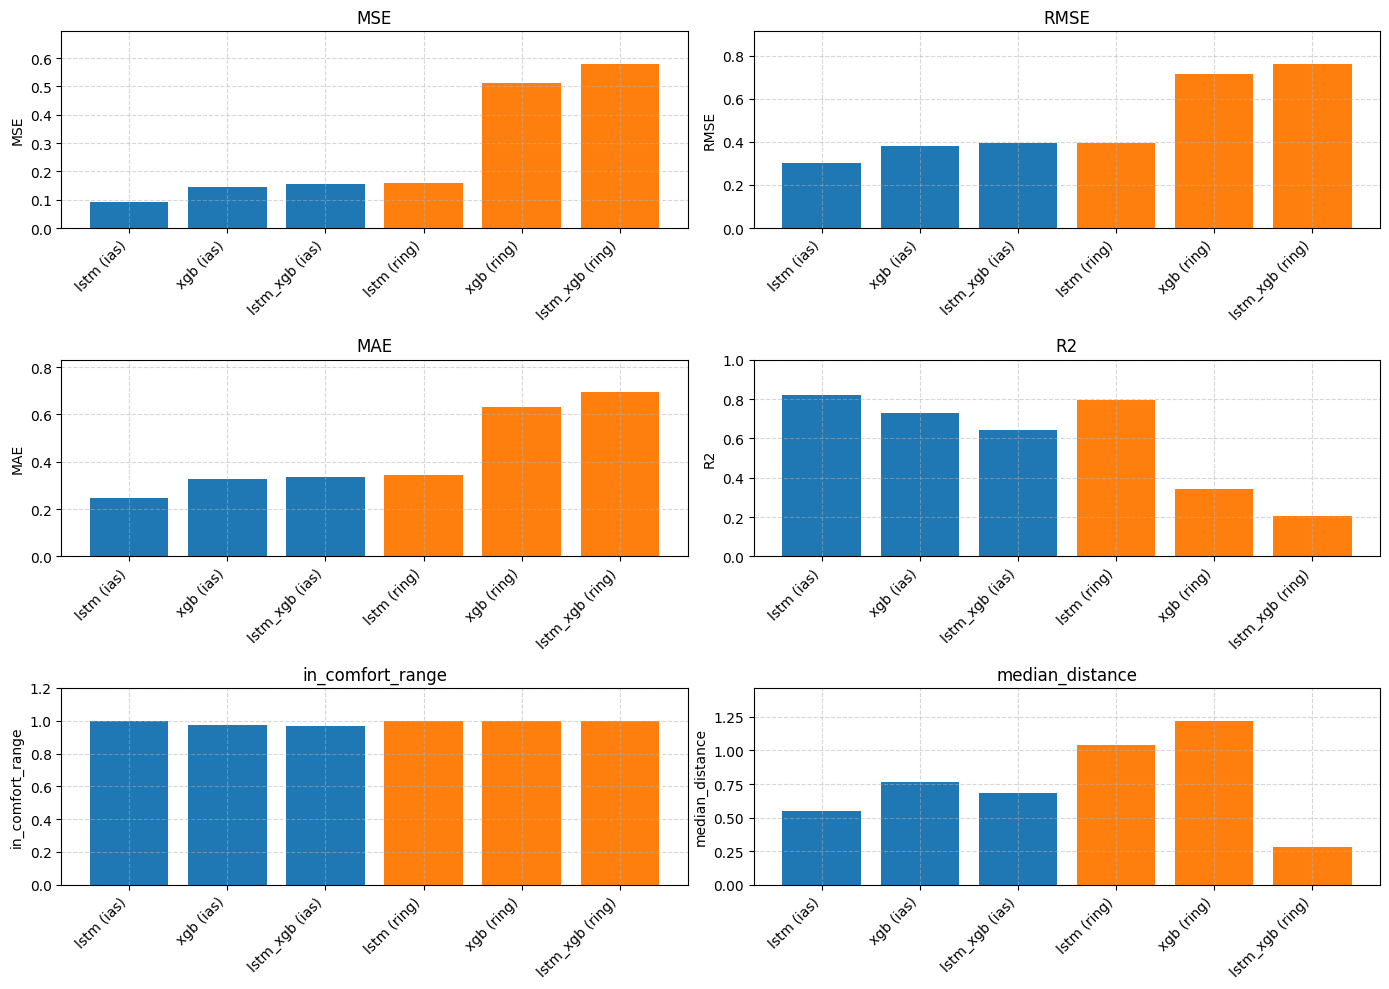

In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 比較モデル
files = [
    "ias_lstm.csv",
    "ias_xgb.csv",
    "ias_lstm_xgb.csv",
    "ring_lstm.csv",
    "ring_xgb.csv",
    "ring_lstm_xgb.csv"
]

# resultsフォルダのパス
results_dir = "../results"

# 読み込みと整理用リスト
data = []

for f in files:
    filepath = os.path.join(results_dir, f)
    df = pd.read_csv(filepath)
    # ファイル名からセンサ名とモデル名を抽出（例：ias_xgb.csv -> ias, xgb）
    base = os.path.splitext(f)[0]
    sensor, model = base.split("_", 1)
    # それぞれの指標を辞書にして追加
    entry = {
        "Sensor": sensor,
        "Model": model,
        "MSE": df.loc[0, "MSE"],
        "RMSE": df.loc[0, "RMSE"],
        "MAE": df.loc[0, "MAE"],
        "R2": df.loc[0, "R2"],
        "in_comfort_range": df.loc[0, "in_comfort_range"],
        "median_distance": df.loc[0, "median_distance"]
     
    }
    data.append(entry)

# DataFrame化
df_results = pd.DataFrame(data)

# 数値出力（表形式で確認）
print("\n=== 各モデルの評価指標 ===")
print(df_results.to_string(index=False))

# 指標ごとにグラフ描画
metrics = ["MSE", "RMSE", "MAE", "R2", "in_comfort_range", "median_distance"]

# 横軸のラベルとしてモデル名+センサ名を作る
labels = df_results["Model"] + " (" + df_results["Sensor"] + ")"

fig, axs = plt.subplots(3, 2, figsize=(14,10))
axs = axs.flatten()

for i, metric in enumerate(metrics):
    axs[i].bar(labels, df_results[metric], color=['#1f77b4' if 'ias' in s else '#ff7f0e' for s in df_results['Sensor']])
    axs[i].set_title(metric)
    axs[i].set_ylabel(metric)
    axs[i].set_xticks(np.arange(len(labels)))
    axs[i].set_xticklabels(labels, rotation=45, ha='right')
    if metric == "R2":
        axs[i].set_ylim(0, 1)
    else:
        axs[i].set_ylim(0, max(df_results[metric])*1.2)
    axs[i].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
